In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 1024
num_epochs = 5
learning_rate = 0.001

# Load the MNIST dataset
train_dataset = MNIST(root='/home/edwin/code/dataset', train=True, transform=ToTensor(), download=True)
test_dataset = MNIST(root='/home/edwin/code/dataset', train=False, transform=ToTensor(), download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the fully connected model
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Create the model, optimizer, and loss function
model = FCNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataset) // batch_size}], Loss: {loss.item():.4f}')

# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')

/home/edwin/anaconda3/envs/SNN_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Accuracy of the model on the test images: 96.61%


In [2]:
# from pgd import PGD
from torchattacks import PGD
atk = PGD(model, eps=16/255, alpha=2/225, steps=10, random_start=True)
atk.set_mode_targeted_random()
print(atk)

Attack mode is changed to 'targeted(random)'.
PGD(model_name=FCNet, device=cuda:0, attack_mode=targeted(random), targeted=True, normalization_used=False, eps=0.06274509803921569, alpha=0.008888888888888889, steps=10, random_start=True)


In [3]:
from torch.utils.data import DataLoader, Subset

# att_dataset = Subset(test_dataset, range(5))
# att_loader = DataLoader(att_dataset, batch_size=1, shuffle=False)
correct = 0
total = 0
model.eval()
for _, (inputs, targets) in enumerate(test_loader):
    inputs = inputs.to(device)
    atk.set_model_training_mode(model_training=False, batchnorm_training=False, dropout_training=False)
    adv_inputs = atk(inputs, targets.to(device))
    with torch.no_grad():
        outputs = model(adv_inputs)
    _, predicted = outputs.cpu().max(1)
    total += float(targets.size(0))
    correct += float(predicted.eq(targets).sum().item())
    break
final_acc = 100 * correct / total

tensor(7)
tensor(7)
67.67578125


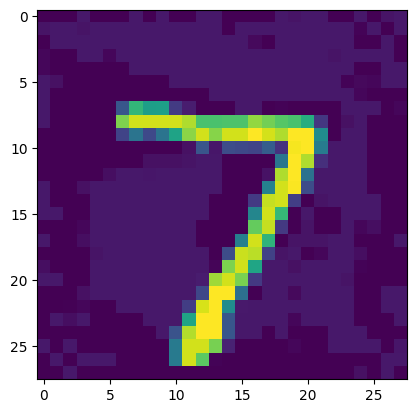

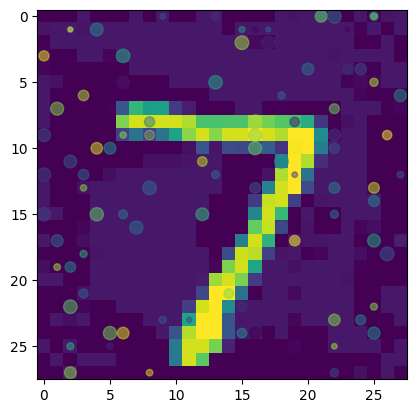

In [5]:
import matplotlib.pyplot as plt 
import numpy as np
plt.imshow(adv_inputs[0].squeeze().cpu())

print(predicted[0])
print(targets[0])

print(final_acc)

# Generate random scatter plot data
image = adv_inputs[0].squeeze().cpu()
# Get the dimensions of the image
height, width, _ = image.shape

# Reshape the image data into a 2D array
image_pixels = image.reshape(-1, 3)

# Extract the color channels
red_channel = image_pixels[:, 0]
green_channel = image_pixels[:, 1]
blue_channel = image_pixels[:, 2]

# Create the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(red_channel, green_channel, blue_channel, c=image_pixels/255.0, s=1)

# Set axis labels
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

# Set plot limits
ax.set_xlim(0, 255)
ax.set_ylim(0, 255)
ax.set_zlim(0, 255)

# Show the plot
plt.show()

In [5]:
adv_inputs[0]

tensor([[[-0.0089, -0.0089, -0.0089,  0.0627,  0.0183,  0.0627, -0.0089,
           0.0627,  0.0627, -0.0089, -0.0089,  0.0627,  0.0627,  0.0627,
          -0.0089, -0.0089,  0.0627,  0.0627, -0.0089,  0.0627, -0.0089,
          -0.0089,  0.0627,  0.0627,  0.0627,  0.0627, -0.0089, -0.0089],
         [-0.0089, -0.0089,  0.0627, -0.0089, -0.0089,  0.0627,  0.0627,
           0.0627,  0.0627,  0.0627,  0.0627,  0.0627,  0.0627,  0.0627,
           0.0627,  0.0627, -0.0089,  0.0627,  0.0627,  0.0627,  0.0627,
           0.0627,  0.0627,  0.0627, -0.0089, -0.0089, -0.0089,  0.0627],
         [ 0.0627, -0.0089, -0.0089, -0.0089,  0.0627,  0.0627,  0.0627,
           0.0627,  0.0627,  0.0627,  0.0627,  0.0627,  0.0627,  0.0627,
           0.0627,  0.0627,  0.0627,  0.0627,  0.0627,  0.0627,  0.0627,
           0.0627,  0.0627,  0.0627, -0.0089, -0.0089,  0.0627, -0.0089],
         [-0.0089,  0.0627, -0.0089,  0.0061,  0.0627,  0.0627,  0.0627,
           0.0627,  0.0627,  0.0627,  0.0627,  0